In [237]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
#import tensorflow as tf
import torch
%matplotlib inline
from torch.autograd import Variable
import torch.optim as  optim
import torch.nn as nn
pd.set_option('display.max_rows', 2000)

# Classifying French Genders using character level LSTM

Nouns in french are divided in two categories, masculine and feminine. The set of rules that categorize genders is quite extensive and based mostly on word endings. There are also a lot of exceptions. We will train a character-level LSTM on french words and predict the gender of each word. 
Concretely, we will feed each character of a word as one-hot vector to a LSTM model and at the end the model will predict the gender of the word.

# Preparing the Data
For this problem we are going to use lexical dictionary which is available for download here
http://www.dicollecte.org/download.php?prj=fr

In [2]:
df = pd.read_csv('~/Data/fr/lexique-dicollecte-fr-v6.0.2/lexique-dicollecte-fr-v6.0.2.txt', delimiter='\t')
df.head(3)

,id,Flexion,Lemme,Étiquettes,Métagraphe (β),Metaphone2,Notes,Sémantique,Étymologie,Sous-dictionnaire,Google 1-grams,Wikipédia,Wikisource,Littérature,Total occurrences,Doublons,Multiples,Fréquence,Indice de fréquence
0,139424,de,de,mg det epi inv,de,T,NaN,@,NaN,*,8818296701,94780970,37051349,6972501,8957101521,1,0,6.074393,9
1,145241,et,et,mg cjco,é,AT,NaN,@,NaN,*,3867624351,22249966,13925141,3823323,3907622781,1,0,2.650013,9
2,180587,à,à,mg prep prepv,a,A,NaN,@,NaN,*,3221974801,20826283,11299713,2919484,3257020281,1,0,2.208797,9


There are many fields in this dataset, but we are only interested in the column Flexion (inflection) and Étiquettes (tags). We select nouns that have tage 'sg' (singular), 'mas' (masguline) or 'fem' (feminine) tags. We also add columns word_len and gender.

In [3]:
nouns = df[df['Étiquettes'].str.contains('nom') & df['Étiquettes'].str.contains('sg') & (df['Étiquettes'].str.contains('mas') | df['Étiquettes'].str.contains('fem'))].copy()
nouns.loc[:, 'word_len'] = nouns['Flexion'].str.len()
nouns.loc[:, 'gender'] = nouns['Étiquettes'].str.contains('mas').values.astype(np.int8)
nouns = nouns[['Flexion', 'Étiquettes', 'word_len', 'gender']]

A few words in the data set contain parenthesis. We remove those rows

In [4]:
nouns = nouns[~nouns['Flexion'].str.contains('\(')]

In [5]:
nouns = nouns.reindex(np.random.permutation(nouns.index))

In [155]:
print('Total nouns ' + str(len(nouns)))
nouns.head(3)

Total nouns 48940


,Flexion,Étiquettes,word_len,gender
146419,lichénification,nom fem sg,15,0
37039,rondeur,nom fem sg,7,0
51382,grattoir,nom mas sg,8,1


There is 48940 nouns in the given dataset.  Having selected the set of words and their genders we convert them to vectors.  First we create a vocabolary of all characters in the dictionary <code>char_indexes</code>. 

In [7]:
char_indexes = {}
char_index = 0
for i in range(0, len(nouns)):
    word = nouns.iloc[i].Flexion
    for j in range(0, len(word)):
        if word[j] not in char_indexes:
            char_indexes[word[j]] = char_index
            char_index += 1
VOCAB_SIZE = len(char_indexes)
VOCAB_SIZE

69

There are 69 distinct characters total. Let's find the index of the character 'a'

In [8]:
char_indexes['a']

7

Next we convert each character into a one-hot vector of the size VOCAB_SIZE with all zeros and a single one corresponding to the character index in <code>char_indexes</code>.

In [9]:
char_vectors = {}
for c, i in char_indexes.items():
    v = np.zeros(VOCAB_SIZE, np.float32)
    v[char_indexes[c]] = 1
    char_vectors[c] = v

In [10]:
char_vectors['a']

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.], dtype=float32)

The vector corresponding the letter 'a' contains a single one in the position <code>char_vectors['a']</code> with all other entries are zeros. Since our dataset is small and can fit all in memory we convert each word into a list of vectors prior to training

In [11]:
word_vectors = []
for i in range(0, len(nouns)):
    word = nouns.iloc[i].Flexion
    temp_list = []
    for j in range(0, len(word)):
        temp_list.append(char_vectors[word[j]])
    word_vectors.append(np.array(temp_list, np.float32))
word_vectors = np.array(word_vectors)    

In [13]:
word_vectors[0].shape

(15, 69)

The first noun in the dataset consists of 15 characters. The vectorized representation of this word is a 15 by 69 matrix. In order to take advantage of batch computation we need to make sure each word in the batch has the same length. A common solution to this problem is to pad sequences to the desired length with dummy characters. Let's create a histogram of word lengths in our data set. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f85709c9a20>]], dtype=object)

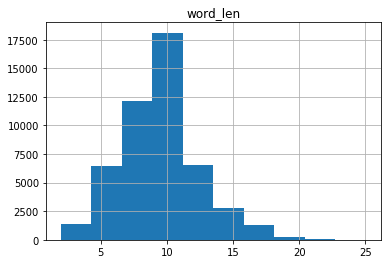

In [14]:
nouns[['word_len']].hist()

The length of french nouns vary from 2 to 20, and even if we excluded very short and very long sentences we would be still left with a wide range of different word lengts and padding all shorter words to some maximum would be very inneficient. Instead, we bucket words based on their lengths and then train and test the model bucket by bucket. 
Our data set is relatively small, so we omit the validation set and split the words in training and test set. 

In [30]:
word_len_vectors_train = {}
word_len_vectors_test = {}
# Keep track of test indices in the nouns data frame
word_len_indices_test = {}
for word_len in range(2, 25):
    word_tensors = []
    targets = []
    for wi in range(0, 25000):
        w = word_vectors[wi]
        if w.shape[0] == word_len:
            word_tensors.append(w.reshape(w.shape[0], -1, VOCAB_SIZE))
            targets.append(torch.LongTensor([int(nouns.iloc[wi].gender)]))            
    word_tensors = np.concatenate(word_tensors, axis=1)
    word_tensors = torch.from_numpy(word_tensors)
    targets = torch.stack(targets)
    targets = torch.unbind(targets, dim=1)[0]
    word_len_vectors_train[word_len] = (word_tensors, targets)
    
    word_tensors = []
    targets = []
    word_len_indices = []
    for wi in range(25000, len(word_vectors)):
        w = word_vectors[wi]        
        if w.shape[0] == word_len:
            word_tensors.append(w.reshape(w.shape[0], -1, VOCAB_SIZE))
            targets.append(torch.LongTensor([int(nouns.iloc[wi].gender)]))
            word_len_indices.append(wi)
    word_tensors = np.concatenate(word_tensors, axis=1)
    word_tensors = torch.from_numpy(word_tensors)
    targets = torch.stack(targets)
    targets = torch.unbind(targets, dim=1)[0]
    word_len_vectors_test[word_len] = (word_tensors, targets)    
    word_len_indices_test[word_len] = np.array(word_len_indices)

In [158]:
word_len_vectors_train[10][0].size()

torch.Size([10, 3262, 69])

# Char LSTM Model
The model we are using is LSTM module followed by a linear layer and Softmax layer that converts the output from the linear layer to probabilities.

In [161]:
class CharLSTMModel(nn.Module):
    
    def __init__(self, n_hidden):
        super(CharLSTMModel, self).__init__()
        self.rnn = nn.LSTMCell(VOCAB_SIZE, n_hidden)
        self.linear = nn.Linear(n_hidden, 2)
        self.softmax = nn.LogSoftmax()
        self.init_weights()
        self.n_hidden = n_hidden
        self.batch_size = batch_size

    def init_weights(self):
        initrange = 0.1
        self.linear.bias.data.fill_(1.0)
        self.linear.weight.data.uniform_(-initrange, initrange)

    def forward(self, input, hidden):
        hx, cx = self.rnn(input, hidden)
        out = self.linear(hx)
        return self.softmax(out), hx, cx                  

    def init_hidden(self, batch_size):        
        return Variable(torch.zeros(batch_size, int(self.n_hidden))).cuda(), \
            Variable(torch.zeros(batch_size, int(self.n_hidden))).cuda() 

Before training let's have our evaluation code ready. 

In [220]:
batch_size = 32
batch_size_eval = 128

def evaluate(word_tensors):
    hx, cx = rnn.init_hidden(word_tensors.size()[1])
    for i in range(word_tensors.size()[0]):
        outputs, hx, cx = rnn(word_tensors[i], (hx, cx))
    return outputs

def to_gender(outputs):
    top_n, top_i = outputs.data.topk(1)  
    return top_i

def evaluate_model():
    correct = 0
    total = 0
    incorrect_indices = []
    
    def do_evaluate(start, end, X, Y, l):
        nonlocal correct, total, incorrect_indices
        x = Variable(X[:, start:end, :].cuda())
        y = Variable(Y[start:end].cuda())
        y_pred = to_gender(evaluate(x))        
        incorrect_batch_indices = (y.data != y_pred).cpu().numpy().nonzero()[0]
        incorrect_batch_indices = incorrect_batch_indices + start
        incorrect_batch_indices = word_len_indices_test[l][incorrect_batch_indices]
        incorrect_indices.extend(list(incorrect_batch_indices))
        correct += (y.data == y_pred).sum()
        total += y_pred.size()[0]
        
    
    for l, test_data in word_len_vectors_test.items(): 
        X = test_data[0]
        Y = test_data[1]
        xi = 0
        for xi in range(batch_size_eval, X.size()[1], batch_size_eval):
            start = xi - batch_size_eval
            end = xi
            do_evaluate(start, end, X, Y, l)
        if xi < X.size()[1] - 1:
            do_evaluate(xi, X.size()[1], X, Y, l)
    return float(correct) / float(total), incorrect_indices

In [221]:
def predict_word(word):
    temp_list = []
    for j in range(0, len(word)):
        temp_list.append(char_vectors[word[j]])
    word_tensor = Variable(torch.from_numpy(np.array(temp_list, np.float32).reshape(len(word), -1, VOCAB_SIZE)).cuda())
    hx, cx = rnn.init_hidden(1) 
    for i in range(word_tensor.size()[0]):
        outputs, hx, cx = rnn(word_tensor[i], (hx, cx)) 
    gender_i = to_gender(outputs)
    print(gender_i[0][0])
    return 'masculine' if gender_i.cpu()[0][0] == 1 else 'feminine'

In [233]:
predict_word('bagasse')

0


'feminine'

In [135]:
torch.LongTensor([1])[0]

1

In [222]:
criterion = nn.NLLLoss()

def train_model(word_tensor, target_tensor,  optimizer):
    hx, cx = rnn.init_hidden(word_tensor.size()[1])

    optimizer.zero_grad()

    for i in range(word_tensor.size()[0]):
        output, hx, cx = rnn(word_tensor[i], (hx, cx))
    loss = criterion(output, target_tensor)
    loss.backward()
    optimizer.step()
    return output, loss.data[0]

In [223]:
n_hidden = 512
n_letters = len(char_indexes)

rnn = CharLSTMModel(n_hidden).cuda()

n_epochs = 50
# Keep track of losses for plotting
current_loss = 0
all_losses = []
accuracies = []

optimizer = optim.Adam(rnn.parameters(), lr = 0.0001)
lens = np.array(list(word_len_vectors_train.keys()))
for epoch in range(0, n_epochs):
    np.random.shuffle(lens)
    epoch_losses = []
    for l in lens:
        train_data = word_len_vectors_train[l]
        X = train_data[0]
        Y = train_data[1]
        for xi in range(batch_size, X.size()[1], batch_size):
            x = Variable(X[:, xi - batch_size:xi, :].cuda())
            y = Variable(Y[xi-batch_size:xi].cuda())
            output, loss = train(y, x, optimizer)
            epoch_losses.append(loss)
        if xi < X.size()[1] - 1:
            x = Variable(X[:,xi:X.size()[1],:].cuda())
            y = Variable(Y[xi:X.size()[1]].cuda())
            output, loss = train(y, x, optimizer)
            epoch_losses.append(loss)
            
    acc, indices = evaluate_model()
    accuracies.append(acc)
    all_losses.append(np.mean(epoch_losses))

# Plotting Results

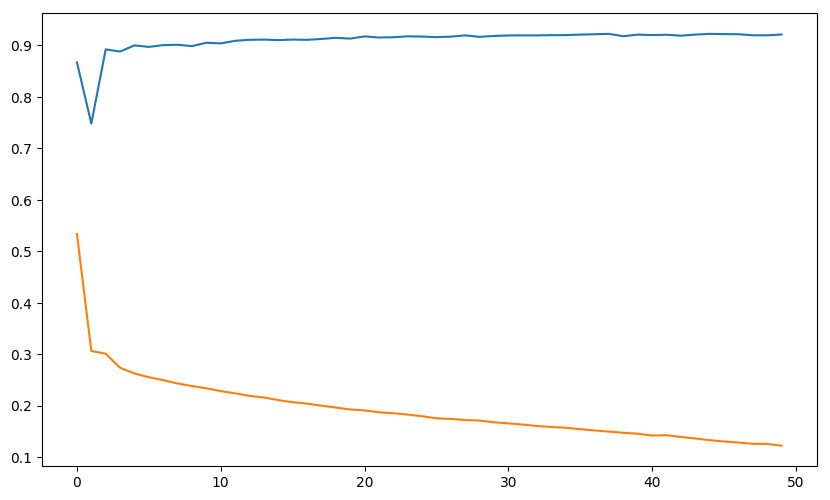

In [224]:
fig = plt.figure(figsize=(10, 6), dpi=100)
plt.plot(accuracies, label='accuracy')
plt.plot(all_losses, label='loss')
plt.show()

In [225]:
accuracy, indices  = evaluate_model()  

We can inspect the misclassified words by selecting rows correcponding to indices

In [238]:
nouns.iloc[indices]

,Flexion,Étiquettes,word_len,gender
567,foi,nom fem sg,3,0
141,loi,nom fem sg,3,0
89,été,nom mas sg,3,1
8909,nef,nom fem sg,3,0
18978,fac,nom fem sg,3,0
19151,âne,nom mas sg,3,1
44347,ure,nom mas sg,3,1
183610,zée,nom mas sg,3,1
19152,âne,nom mas sg,3,1
7037,clé,nom fem sg,3,0
